# 4. 신경망 학습

In [1]:
import numpy as np
import sys,os
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt
sys.path.append(os.pardir)
%matplotlib inline

### 오차제곱합(Sum of Squares for error,SSE)

In [2]:
def sum_squares_error(y,t):
    return 0.5 * np.sum((y-t)**2)

In [3]:
t = [0,0,1,0,0,0,0,0,0,0] # 2 원-핫 인코딩

y = [0.1,0.05,0.6,.0,.05,.1,.0,.1,.0,.0]

sum_squares_error(np.array(y),np.array(t))


0.09750000000000003

In [4]:
y = [.1,.05,.1,.0,.05,.1,.0,.6,.0,.0] # 신경망의 출력값이 7이 가장 높은 경우 
sum_squares_error(np.array(y),np.array(t))


0.5975

### 교차 엔트로피 오차(Cross Entropy Error,CEE)

In [5]:
def cross_entropy_error(y,t):
    delta = 1e-7 # 로그 수식 안 값이 0이 되지 않게 하기 위함
    return -np.sum(t*np.log(y+delta))

In [6]:
t = [0,0,1,0,0,0,0,0,0,0] # 2 원-핫 인코딩

y = [0.1,0.05,0.6,.0,.05,.1,.0,.1,.0,.0]

cross_entropy_error(np.array(y),np.array(t))

0.510825457099338

In [7]:
y = [.1,.05,.1,.0,.05,.1,.0,.6,.0,.0] # 신경망의 출력값이 7이 가장 높은 경우 

cross_entropy_error(np.array(y),np.array(t))


2.302584092994546

### 미니배치(mini-batch)

In [8]:
(x_train,y_train),(x_test,y_test) = load_mnist(normalize=True,one_hot_label=True)
print(x_train.shape)
print(y_train.shape)

(60000, 784)
(60000, 10)


In [9]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size,batch_size) # 지정한 범위의 수 중에서 무작위로 원하는 갯수만 꺼낼 수 있음 
x_batch = x_train[batch_mask]
y_batch = y_train[batch_mask]

### (배치용) 교차 엔트로피 오차 구현

In [10]:
def cross_entropy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y+1e-7)) / batch_size

In [11]:
def cross_entropy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size),t]+1e-7)) / batch_size

### 수치 미분

In [12]:
# 나쁜 구현의 예 
def numerical_diff1(f,x):
    h = 1e-50
    return (f(x+h) - f(x)) / h

In [13]:
# 반올림 오차(rounding error)
np.float32(1e-50)

0.0

In [14]:
# 중앙 차분(==중심 차분)
def numerical_diff2(f,x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

In [15]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

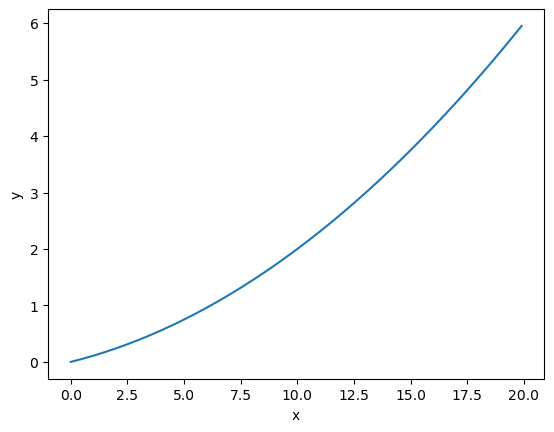

In [16]:
x = np.arange(.0,20.,.1)
y = function_1(x)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y)
plt.show()

In [17]:
print(numerical_diff1(function_1,5))
print(numerical_diff1(function_1,10))

0.0
0.0


In [18]:
print(numerical_diff2(function_1,5))
print(numerical_diff2(function_1,10))

0.1999999999990898
0.2999999999986347


In [19]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [20]:
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

In [21]:
numerical_diff2(function_tmp1,3.0)

6.00000000000378

In [22]:
def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

In [23]:
numerical_diff2(function_tmp2,4.0)

7.999999999999119

### 기울기(Gradient)

In [24]:
def numerical_gradient(f,x):
    h = 1e-4 
    grad = np.zeros_like(x)

    for idx in range(x.size): # 3. ndarray.size : 전체 원소의 갯수 반환
        tmp_val = x[idx]

        # f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

In [25]:
numerical_gradient(function_2,np.array([3.0,4.0]))

array([6., 8.])

In [26]:
numerical_gradient(function_2,np.array([.0,2.]))

array([0., 4.])

In [27]:
numerical_gradient(function_2,np.array([3.,0.]))

array([6., 0.])

### 경사법

In [28]:
def gradient_descent(f,init_x,lr=0.01,step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f,x)
        x = x - lr*grad
        
    return x

In [29]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0,4.0])

gradient_descent(function_2,init_x,lr=0.1,step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

In [30]:
from common.functions import softmax , cross_entropy_error
from common.gradient import numerical_gradient

class SimpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)
    def predict(self,x):
        return np.dot(x,self.W)
    def loss(self,x,t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y,t)

        return loss


In [31]:
net = SimpleNet()
print(net.W)

[[ 0.38086196  1.06402576  0.87179079]
 [-0.02562088  1.18705773 -2.15486764]]


In [32]:
x = np.array([.6,.9])
p = net.predict(x)
print(p)

[ 0.20545839  1.70676741 -1.4163064 ]


In [33]:
np.argmax(p)

1

In [34]:
t = np.array([0,0,1])

In [35]:
net.loss(x,t)

3.3596122607574594

In [36]:
def f(W):
    return net.loss(x,t)

In [37]:
dW = numerical_gradient(f,net.W)
print(dW)

[[ 0.10553856  0.47361059 -0.57914916]
 [ 0.15830785  0.71041589 -0.86872373]]


### 2층 신경망 클래스 구현하기

In [38]:
from common.functions import *
from common.gradient import numerical_gradient

- np.random.rand : uniform 분포에서 균일하게 추출 (0에서 1사이)
- np.random.randn : 표준 정규 분포에서 추출 

In [52]:
class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
        self.params={}
        self.params['W1'] = weight_init_std * np.random.randn(input_size,hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size,output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self,x):
        W1,W2 = self.params['W1'],self.params['W2']
        b1,b2 = self.params['b1'],self.params['b2']

        a1 = np.dot(x,W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        y = softmax(a2)

        return y

    def loss(self,x,t):
        y = self.predict(x)

        return cross_entropy_error(y,t)

    def accuracy(self,x,t):
        y = self.predict(x)
        
        y = np.argmax(y,axis=1)
        t = np.argmax(t,axis=1)

        accuracy = np.sum(y==t) / float(x.shape[0])

        return accuracy

    def numerical_gradient(self,x,t):
        loss_W = lambda W : self.loss(x,t)

        grads={}
        grads['W1'] = numerical_gradient(loss_W,self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W,self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W,self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W,self.params['b2'])

        return grads

In [53]:
net = TwoLayerNet(input_size=784,hidden_size=100,output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [54]:
x = np.random.rand(100,784)
y = net.predict(x)

In [57]:
x = np.random.rand(100,784)
t = np.random.rand(100,10)

grads = net.numerical_gradient(x,t)

print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [61]:
from ch04.two_layer_net import TwoLayerNet

(x_train,t_train) , (x_test,t_test) = load_mnist(normalize=True,one_hot_label=True)

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

iters_num=10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = .1

iter_per_epoch = max(train_size / batch_size,1)

network = TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.numerical_gradient(x_batch,t_batch)

    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train,t_train)
        test_acc = network.accracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc |" + str(train_acc)+","+str(test_acc))

KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(iters_num),train_loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()